In [1]:
import numpy as np
import matplotlib.pyplot as plt
from chebpy import chebfun

The function ``chebfun`` behaves in essentially the same way as its MATLAB counterpart. A good way to begin is to type:

In [2]:
x = chebfun('x', [0, 10])
x

chebfun column (1 smooth piece)
       interval       length     endpoint values
[       0,      10]        2         0       10
vertical scale =  10

What's happened here is we've instantiated a numerical representation of the identity function on the interval `[0,10]` and assigned this to a computer variable `x`. This particular representation has length 2, meaning that it is a degree one polynomial defined via two degrees of freedom (as you would expect of a linear function).

An intuitive set of composition-like operations can now be performed. For instance here is the specification of a function `f` that oscillates with two modes:

In [3]:
f = np.sin(x) + np.sin(5*x)
f

chebfun column (1 smooth piece)
       interval       length     endpoint values
[       0,      10]       58  -8.9e-16    -0.81
vertical scale =   2

The zeros of f can be computed via `roots`, which behind the scenes is implemented via a recursive subdivision algorithm in which a number of Colleague Matrix eigenvalue sub-problems are solved:

In [4]:
r = f.roots()
r

array([0.        , 0.78539816, 1.04719755, 2.0943951 , 2.35619449,
       3.14159265, 3.92699082, 4.1887902 , 5.23598776, 5.49778714,
       6.28318531, 7.06858347, 7.33038286, 8.37758041, 8.6393798 ,
       9.42477796])

By default ChebPy computations are accurate to machine precision, or approximately fifteen digits in double-precision arithmetic (see also the `UserPrefs` interface [here](./implementation.ipynb)).

We can verify this for the computed roots of `f` by typing:

In [5]:
f(r)

array([-8.88178420e-16,  0.00000000e+00,  0.00000000e+00,  4.44089210e-16,
       -5.55111512e-16, -1.33226763e-15,  5.82867088e-16,  6.10622664e-16,
        2.13717932e-15, -4.44089210e-16,  2.33146835e-15,  8.18789481e-16,
       -2.99760217e-15, -3.66373598e-15, -1.73472348e-15, -7.10542736e-15])

The function and its roots can be plotted together as follows:


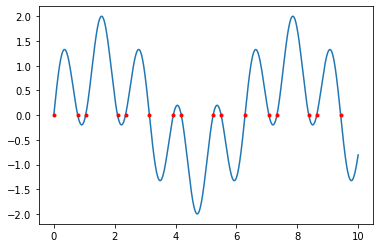

In [6]:
ax = f.plot()
ax.plot(r, f(r), '.r')
plt.show()

Calculus operations are natively possible with Chebfun objects. For example here is the derivative and indefinite integral of `f`:

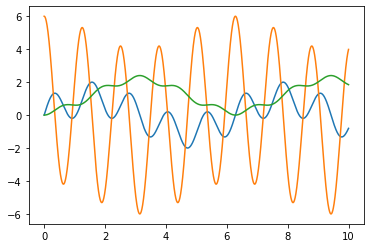

In [7]:
Df = f.diff()
If = f.cumsum()
f.plot()
Df.plot()
If.plot()
plt.show()

One can verify analytically that the exact value of the definite integral here is `1.2 - cos(10) - 0.2cos(50)`.

This matches our numerical integral (via Clenshaw-Curtis quadrature), which is computable in ChebPy via the `sum` command.

In [8]:
I_ana = 1.2 - np.cos(10) - 0.2 * np.cos(50)
I_num = f.sum()
print(f'analytical : I={I_ana}')
print(f'    ChebPy : I={I_num}')

analytical : I=1.8460783233780296
    ChebPy : I=1.8460783233780311


## Discontinuities

Chebfun is capable of handling certain classes of mathematical nonsmoothness. For example, here we compute the pointwise maximum of two functions, which results in a 'piecewise-smooth' concatenation of twelve individual pieces (in Chebfun & ChebPy terminology this is a collection of 'Funs'). The breakpoints between the pieces (Funs) have been determined by ChebPy in the background by solving the corresponding root-finding problem.

In [9]:
g = x/5 - 1
h = f.maximum(g)
h

chebfun column (12 smooth pieces)
       interval       length     endpoint values
[       0,     3.2]       32    -2e-15    -0.36
[     3.2,     3.9]        2     -0.36    -0.23
[     3.9,     4.2]       14     -0.23    -0.15
[     4.2,     5.3]        2     -0.15    0.051
[     5.3,     5.5]       12     0.051    0.092
[     5.5,     6.3]        2     0.092     0.27
[     6.3,       7]       17      0.27     0.39
[       7,     7.5]        2      0.39     0.49
[     7.5,     8.2]       17      0.49     0.65
[     8.2,     8.8]        2      0.65     0.77
[     8.8,     9.3]       15      0.77     0.85
[     9.3,      10]        2      0.85        1
vertical scale =   2    total length = 119

Here's a plot of both `f` and `g`, and their maximum, `h`:

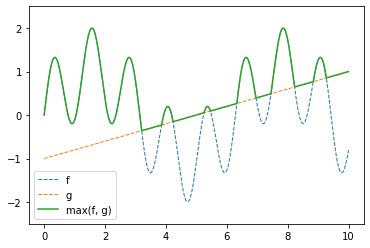

In [10]:
fig, ax = plt.subplots()
f.plot(ax=ax, linewidth=1, linestyle='--', label='f')
g.plot(ax=ax, linewidth=1, linestyle='--', label='g')
h.plot(ax=ax, label='max(f, g)')
ax.set_ylim([-2.5, 2.5])
ax.legend()
plt.show()

The function `h` is a further Chebfun representation (Chebfun operations such as this are closures) and thus the same set of operations can be applied as normal. Here for instance is the exponential of `h` and its integral:

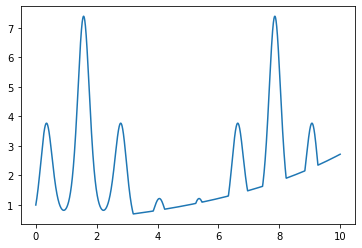

integral: 22.090079782676824


In [11]:
np.exp(h).plot()
plt.show()
print(f'integral: {np.exp(h).sum()}')

## Probability distributions

Here's a further example, this time related to statistics. We consider the following Chebfun representation of the standardised Gaussian distribution, using a sufficiently wide interval as to facilitate a machine-precision representation. On this occasion we utlilise a slightly different (but still perfectly valid) approach to construction whereby we supply the function handle (in this case, a Python lambda, but more generally any object in possession of a `__call__` attribute) together with the interval of definition.

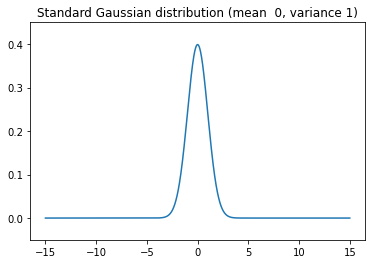

In [12]:
def gaussian(x): return 1/np.sqrt(2*np.pi) * np.exp(-.5*x**2)
pdf = chebfun(gaussian, [-15, 15])
ax = pdf.plot()
ax.set_ylim([-.05, .45])
ax.set_title('Standard Gaussian distribution (mean  0, variance 1)')
plt.show()

The integral of any probability density function should be unity, and this is the case for our numerical approximation:

In [13]:
print(f'integral : {pdf.sum()}')

integral : 0.9999999999999998


Suppose we wish to generate quantiles of the distribution. This can be achieved as follows. First we form the cumulative distribution function,
computed as the indefinite integral (`cumsum`) of the density:

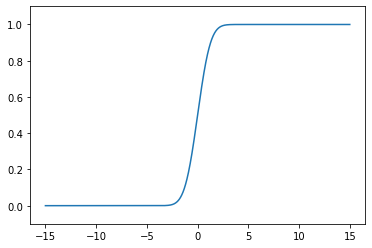

In [14]:
cdf = pdf.cumsum()
ax = cdf.plot()
ax.set_ylim([-0.1, 1.1])
plt.show()

Then it is simply a case of utilising the `roots` command to determine the standardised score (sometimes known as 'z-score') corresponding to the quantile of interest. For example:

In [15]:
print('quantile    z-score ')
print('--------------------')
for quantile in np.arange(.1, .0, -.01):
    roots = (cdf-quantile).roots()
    print(f'  {quantile*100:2.0f}%       {roots[0]:+5.3f}')

quantile    z-score 
--------------------
  10%       -1.282
   9%       -1.341
   8%       -1.405
   7%       -1.476
   6%       -1.555
   5%       -1.645
   4%       -1.751
   3%       -1.881
   2%       -2.054
   1%       -2.326


Other distributional properties are also computable. Here's how we can compute the first four normalised and centralised moments (Mean, Variance, Skew, Kurtosis):

In [16]:
x = pdf.x  # identity on domain of pdf
m1 = (pdf*x).sum()
m2 = (pdf*(x-m1)**2).sum()
m3 = (pdf*(x-m1)**3).sum() / m2**1.5
m4 = (pdf*(x-m1)**4).sum() / m2**2
print('    mean = {:+.15f}'.format(m1))
print('variance = {:+.15f}'.format(m2))
print('    skew = {:+.15f}'.format(m3))
print('kurtosis = {:+.15f}'.format(m4))

    mean = -0.000000000000001
variance = +1.000000000000000
    skew = +0.000000000000124
kurtosis = +2.999999999998626
